Double_layer_Neural_Network

Contents:

1) Importing libraries

2) Extracting data

3) Observing data using heatmap

4) Operations on raw data to make it compatible for model

5) Implementing double layer neural network model

6) Plotting accuracy of model with each iteration

7) Testing the model on the test set

Accuracy of 94.17% on test set when no. of iterations = 100

In [2]:
import numpy as np
import pandas as pd
import gzip
import struct
import matplotlib.pyplot as plt
import seaborn as sn

In [16]:
#used to read image files

def read_image(file):
    #Python struct module can be used in handling binary data
    #stored in files, database or from network connections etc.
    magic, n, rows, cols = struct.unpack('>IIII', file.read(16))
    
    #here assert is used to check some statements
    assert magic == 0x00000803   #magic number
    assert rows == 28
    assert cols == 28
    
    #file.read(): read the file data and store it in variable 'file_content'
    file_content = file.read()
    assert n * rows * cols == len(file_content)
    
    #frombuffer: Interpret a buffer as a 1-dimensional array
    #u1 = uint8...output range (-128 to 127)
    rawdata = np.frombuffer(file_content, dtype = '>u1', count = n*rows*cols)
    
    return rawdata.reshape(n, rows, cols).astype(np.float32) / 255.0


#used to read label files
def read_label(file):
    magic , n = struct.unpack('>II', file.read(8))
    assert magic == 0x00000801
    file_content = file.read()
    assert n == len(file_content)
    return np.frombuffer(file_content, dtype = '>u1', count = n)

train_x = read_image(gzip.open('/home/satish/Downloads/train-images-idx3-ubyte.gz', 'rb'))
train_y = read_label(gzip.open('/home/satish/Downloads/train-labels-idx1-ubyte.gz', 'rb'))
test_x = read_image(gzip.open('/home/satish/Downloads/t10k-images-idx3-ubyte.gz', 'rb'))
test_y = read_label(gzip.open('/home/satish/Downloads/t10k-labels-idx1-ubyte.gz', 'rb'))

In [17]:
print(train_x.shape)    #60000(images)×28(y)×28(x) ; dtype=float32
print(train_y.shape)    #60000(labels)             ; dtype=uint8
print(test_x.shape)     #10000(images)×28(y)×28(x) ; dtype=float32
print(test_y.shape)     #10000(labels)             ; dtype=uint8

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [18]:
train_y

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [19]:
test_y

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [138]:
#train_x.shape[0]  #60000
#train_x.shape[1]  #28
#train_x.shape[2]  #28

#train_x[0].shape  #(28,28)

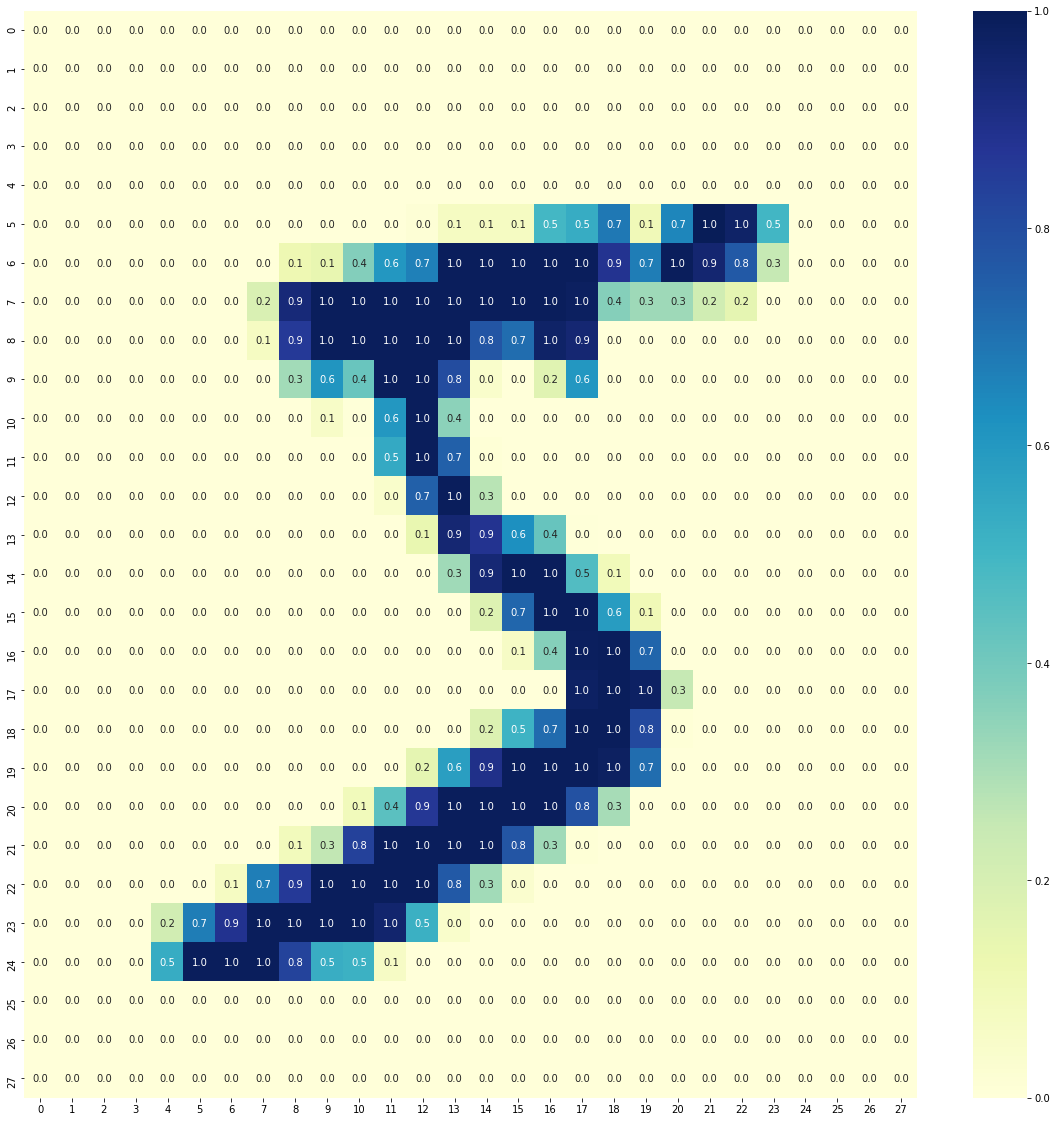

In [251]:
#Visualizing the Data

f, ax = plt.subplots(figsize=(20, 20))
sn.heatmap(train_x[0], annot=True, fmt='.1f', cmap='YlGnBu')
plt.show()

#color_map : RdYlGn; YlGnBu; coolwarm; seismic; PRGn
#train_x[-1] : 8........last  element in train_x
#train_x[0]  : 5........1st   element in train_x
#train_x[1]  : 0........2nd   element in train_x
#train_x[2]  : 4........3rd   element in train_x

In [231]:
#converting 3D-matrix to 2D-matrix
def image_to_vector(x):
    n = x.shape[0]
    rows = x.shape[1]
    cols = x.shape[2]
    x1 = x.reshape(n,rows*cols) #Flatten: (60000x28x28) -> (60000x784)
    return x1

#converting series to 2D-matrix
def label_to_onehot(y,k):
    return np.eye(k)[y]

x_train = image_to_vector(train_x)        #(60000, 784)
x_test = image_to_vector(test_x)          #(10000, 784)
y_train = label_to_onehot(train_y, 10)    #(60000, 10)
y_test = label_to_onehot(test_y, 10)          #(10000, )

In [232]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoid_deriv(z):
    return sigmoid(z)*(1-sigmoid(z))

m = len(x_train)  #number of training examples
np.random.seed(0) #to avoid random initialisation of weights each time

#initialisation of weights
w0 = 0.001 * np.random.randn(20, 784+1)   #(20, 785)
w1 = 0.001 * np.random.randn(10, 20+1)   #(10, 21)

In [243]:
#initialisation of deltas used in backpropagation
layer1_del = np.zeros((10, 21))
layer2_del = np.zeros((20, 785))

#learning rate
alpha = 0.1

#to store errors and accuracy at each iteration
errors = []
accuracy = []

for i in range(100):
    #Forward propagation
    a0 = np.concatenate((np.ones((len(x_train),1)), x_train), axis=1) #(60000, 785)

    z1 = np.dot(a0, w0.T)  #(60000, 785) * (785, 20)
    a1 = sigmoid(z1)       #(60000, 20)
    _a1 = np.concatenate((np.ones((len(a1),1)), a1), axis=1)     #(60000, 21)
    
    z2 = np.dot(_a1, w1.T) #(60000, 21) * (21, 10)
    a2 = sigmoid(z2)   #(60000, 10)

    
    #Backward propagation
    layer2_error = a2 - y_train   #(60000, 10)
    layer2_delta = layer2_error * sigmoid_deriv(a2) #(60000, 10) ; element-wise multiplication

    layer1_error = np.dot(layer2_delta, w1) #(60000, 21)
    layer1_error_ = layer1_error[:,1:]      #(60000, 20)

    layer1_del += np.dot(layer2_error.T, _a1) #(10, 21)
    dw1 = (layer1_del/m)  #(10, 21)
    
    #updating weight w1
    w1 -= alpha*dw1     #(10, 21)

    layer0_del += np.dot(layer1_error_.T, a0)
    dw0 = (layer0_del/m)
    
    #updating weight w0
    w0 -= alpha*dw0
    
    error = np.mean(np.abs(layer2_error))
    errors.append(error)
    accuracy.append((1-error)*100)

Text(0.5, 1.0, 'Accuracy vs Iteration')

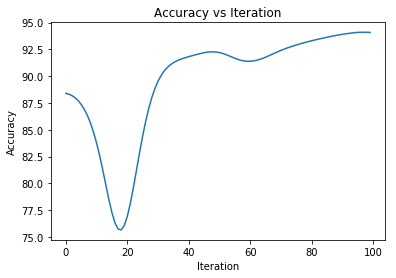

In [244]:
#Depicting accuracy at nth iteration

plt.plot(np.arange(100), accuracy)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Iteration')

In [246]:
#Depicting error at nth iteration

# plt.plot(np.arange(100), errors)
# plt.xlabel('Iteration')
# plt.ylabel('Error')
# plt.title('Error vs Iteration')

In [247]:
#Testing the neural network on test set

a0 = np.concatenate((np.ones((len(x_test),1)), x_test), axis=1) #(10000, 785)
z1 = np.dot(a0, w0.T)  #(10000, 785) * (785, 20)
a1 = sigmoid(z1)       #(10000, 20)
_a1 = np.concatenate((np.ones((len(a1),1)), a1), axis=1)     #(10000, 21)  
z2 = np.dot(_a1, w1.T) #(10000, 21) * (21, 10)
a2 = sigmoid(z2)   #(10000, 10)

error_test = np.mean(np.abs(a2 - y_test))  #mean error on the test set
accuracy_test = (1 - error_test)*100    #accuracy on the test set
print('Accuracy = ', accuracy_test, '%')

Accuracy =  94.16754854507126 %


In [249]:
#manual cross-checking of the neural network

print(np.argmax(a2[6]))
print(np.argmax(y_test[6]))

4
4
